In [ ]:
# mount to google drive
import os
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/tts-gan

/content/drive/MyDrive/Colab Notebooks/tts-gan


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from GANModels import *
import numpy as np
import os


In [ ]:
# Define model paths
model_paths = {
    'left_hand': '/content/drive/MyDrive/Colab Notebooks/StackedDataAugmentation/GANTraining/logs/GAN_left_hand_exp_2025_06_25_15_45_22/Model/checkpoint',
    # 'right_hand': '/content/drive/MyDrive/Colab Notebooks/tts-gan/logs/GAN_right_hand_exp_2025_06_23_20_11_48/Model/checkpoint',
    # 'both_hands': '/content/drive/MyDrive/Colab Notebooks/tts-gan/logs/GAN_both_hands_exp_2025_06_24_05_36_15/Model/checkpoint',
    # 'both_feet': '/content/drive/MyDrive/Colab Notebooks/tts-gan/logs/GAN_both_feet_exp_2025_06_23_20_37_14/Model/checkpoint',
    # 'rest_model': '/content/drive/MyDrive/Colab Notebooks/tts-gan/logs/GAN_rest_exp_2025_06_23_20_50_44/Model/checkpoint'
}

In [ ]:
# Generator parameters (adjust to match training config)
seq_len = 640
channels = 64
latent_dim = 100
sample_size = 1000

In [ ]:
# Synthetic EEG Dataset Class
class SyntheticEEGDataset(Dataset):
    def __init__(self, model_paths, sample_size=1000, normalize=True):
        self.sample_size = sample_size
        self.synthetic_data = []
        self.labels = []
        self.class_to_label = {cls: idx for idx, cls in enumerate(model_paths.keys())}
        self.normalize = normalize

        for class_name, model_path in model_paths.items():
            print(f"Loading model for {class_name}...")
            generator = Generator(seq_len=seq_len, channels=channels, latent_dim=latent_dim)
            checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # or 'cuda' if using GPU

            # checking if checkpoint exists
            if 'gen_state_dict' in checkpoint:
                generator.load_state_dict(checkpoint['gen_state_dict'])
            elif 'model_state_dict' in checkpoint:
                generator.load_state_dict(checkpoint['model_state_dict'])
            else:
                raise KeyError("Checkpoint missing 'gen_state_dict' or 'model_state_dict'")

            generator.eval()

            # Generate synthetic samples
            z = torch.randn(sample_size, latent_dim)
            with torch.no_grad():
                synthetic_samples = generator(z)

            self.synthetic_data.append(synthetic_samples.numpy())
            self.labels.append(np.full((sample_size, 1), self.class_to_label[class_name]))

        # Combine all class data
        self.synthetic_data = np.concatenate(self.synthetic_data, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)

        # print(f"Generated synthetic dataset shape: {self.synthetic_data.shape}")
        # print(f"Generated labels shape: {self.labels.shape}")

    def __len__(self):
        return len(self.synthetic_data)

    def __getitem__(self, idx):
      x = self.synthetic_data[idx]
      label = self.labels[idx]

      if self.normalize:
        x = (x - x.mean(axis=-1, keepdims=True))/ (x.std(axis=-1, keepdims=True) + 1e-8)

      return torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.long)



In [21]:
# Instantiate dataset and dataloader
synthetic_dataset = SyntheticEEGDataset(model_paths, sample_size=1000, normalize=True)
synthetic_loader = DataLoader(synthetic_dataset, batch_size=32, shuffle=True)

Loading model for left_hand...
Generated synthetic dataset shape: (1000, 64, 1, 640)
Generated labels shape: (1000, 1)


In [ ]:
# Example: Iterate over the dataloader
for batch in synthetic_loader:
    X_syn, y_syn = batch
    print(f"Synthetic batch shape: {X_syn.shape}")
    print(f"Labels shape: {y_syn.shape}")
    break  # Remove this to iterate over the whole dataset

Synthetic batch shape: torch.Size([32, 64, 1, 640])
Labels shape: torch.Size([32, 1])


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import numpy as np

def flatten_samples(dataset, num_samples=500):
  X_flat = []
  for i in range(min(len(dataset), num_samples)):
    x, _ = dataset[i]
    X_flat.append(x.squeeze().flatten().numpy()) # shape: (channels * seq_len)

  return X_flat

In [22]:
def get_flat_synthetic_class_samples(synthetic_loader, class_idx, num_samples=300):
  """
  parameters:
  synthetic_loader: synthetic dataset loader that returns rows of data
  class_idx: int value of class to return
  num_samples: int value of samples to return

  returns:
  returns n rows of data
  """

  X_flat = []
  count = 0
  for x_batch, y_batch in synthetic_loader:
    for x, y in zip(x_batch, y_batch):
      if y.item() == class_idx:
        x = x.squeeze().flatten().numpy()
        X_flat.append(x)
        count += 1
        if count >= num_samples:
          return X_flat

  return X_flat

In [ ]:
# List of classes
eeg_classes = ['left_hand', 'right_hand', 'both_hands', 'both_feet', 'rest']

label_map = {
    'left_hand': 0,
    'right_hand': 1,
    'both_hands': 2,
    'both_feet': 3,
    'rest': 4
}


In [ ]:
from EEGMMIDBDatasetLoaderV2 import EEGMMIDBDataset
real_dataset_by_class = {
    cls: EEGMMIDBDataset(
        pickle_path='/content/drive/MyDrive/eeg_data/eegmmidb_train_df.pkl',
        target_class=cls
    )
    for cls in eeg_classes
}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

PCA for Class left_hand
real flat shape: (300, 40960)
fake flat shape: (300, 40960)


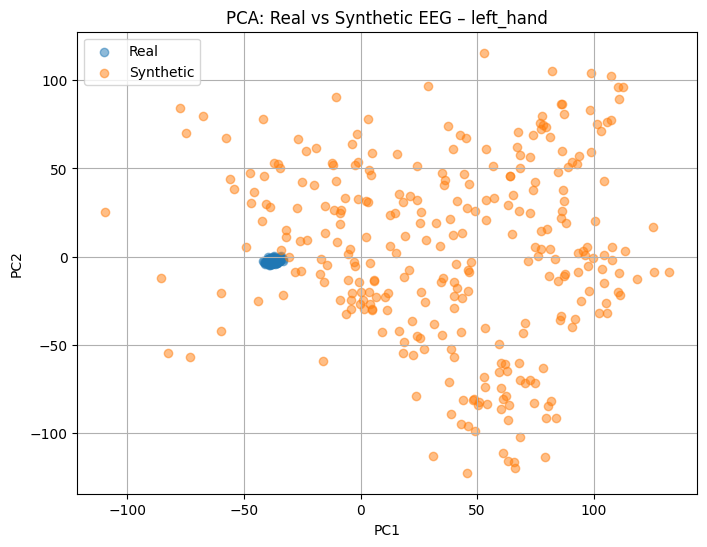

In [23]:
# iterating and doing PCA comparison for each class
eeg_classes = ['left_hand']

for cls in eeg_classes:
  print(f"PCA for Class {cls}")

  # convert class name to int
  class_idx = label_map[cls]

  # get real data
  real_flat = flatten_samples(real_dataset_by_class[cls], num_samples=300)
  print(f'real flat shape: {np.array(real_flat).shape}')

  # get synthetic data from dataloader
  synthetic_flat = get_flat_synthetic_class_samples(synthetic_loader, class_idx=class_idx, num_samples=300)
  print(f'fake flat shape: {np.array(synthetic_flat).shape}')



  # combine and label
  X = np.vstack([real_flat, synthetic_flat])
  y = np.array([0] * len(real_flat) + [1] * len(synthetic_flat))  # 0=real, 1=synthetic

  # PCA
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X)

  # plot
  plt.figure(figsize=(8, 6))
  plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Real', alpha=0.5)
  plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Synthetic', alpha=0.5)
  plt.title(f"PCA: Real vs Synthetic EEG – {cls}")
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.legend()
  plt.grid(True)
  plt.show()



In [ ]:
len(real_dataset_by_class["left_hand"])
len()

1717

In [43]:
def plot_eeg_signals_general(
    dataset, label="EEG", n=5, sampling_rate=160, spacing=2.5, figsize_scale=3.0
):
    """
    Plots EEG signals from a dataset (real or synthetic).

    Args:
        dataset: A PyTorch-style Dataset returning (signal_tensor, label)
        label (str): Label for title (e.g. "Real", "Synthetic")
        n (int): Number of samples to plot
        sampling_rate (int): Sampling rate in Hz
        spacing (float): Controls vertical space between channels
        figsize_scale (float): Multiplier for figure height
    """
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axs = plt.subplots(n, 1, figsize=(14, figsize_scale * n))
    if n == 1:
        axs = [axs]

    for i in range(n):
        eeg_tensor, _ = dataset[i]
        eeg_signal = eeg_tensor.squeeze().numpy()  # shape: (64, 640)

        # Normalize each channel
        eeg_signal = (eeg_signal - eeg_signal.mean(axis=1, keepdims=True)) / (
            eeg_signal.std(axis=1, keepdims=True) + 1e-8
        )

        time = np.arange(eeg_signal.shape[1]) / sampling_rate
        offset = 0
        offset_step = np.max(np.abs(eeg_signal)) * spacing

        axs[i].set_title(f"{label} EEG sample {i}", fontsize=14)
        for ch in range(eeg_signal.shape[0]):
            axs[i].plot(time, eeg_signal[ch] + offset, linewidth=0.7)
            offset += offset_step

        axs[i].set_xlabel("Time (s)", fontsize=12)
        axs[i].set_ylabel("Amplitude + offset", fontsize=12)
        axs[i].tick_params(axis="both", labelsize=10)
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()


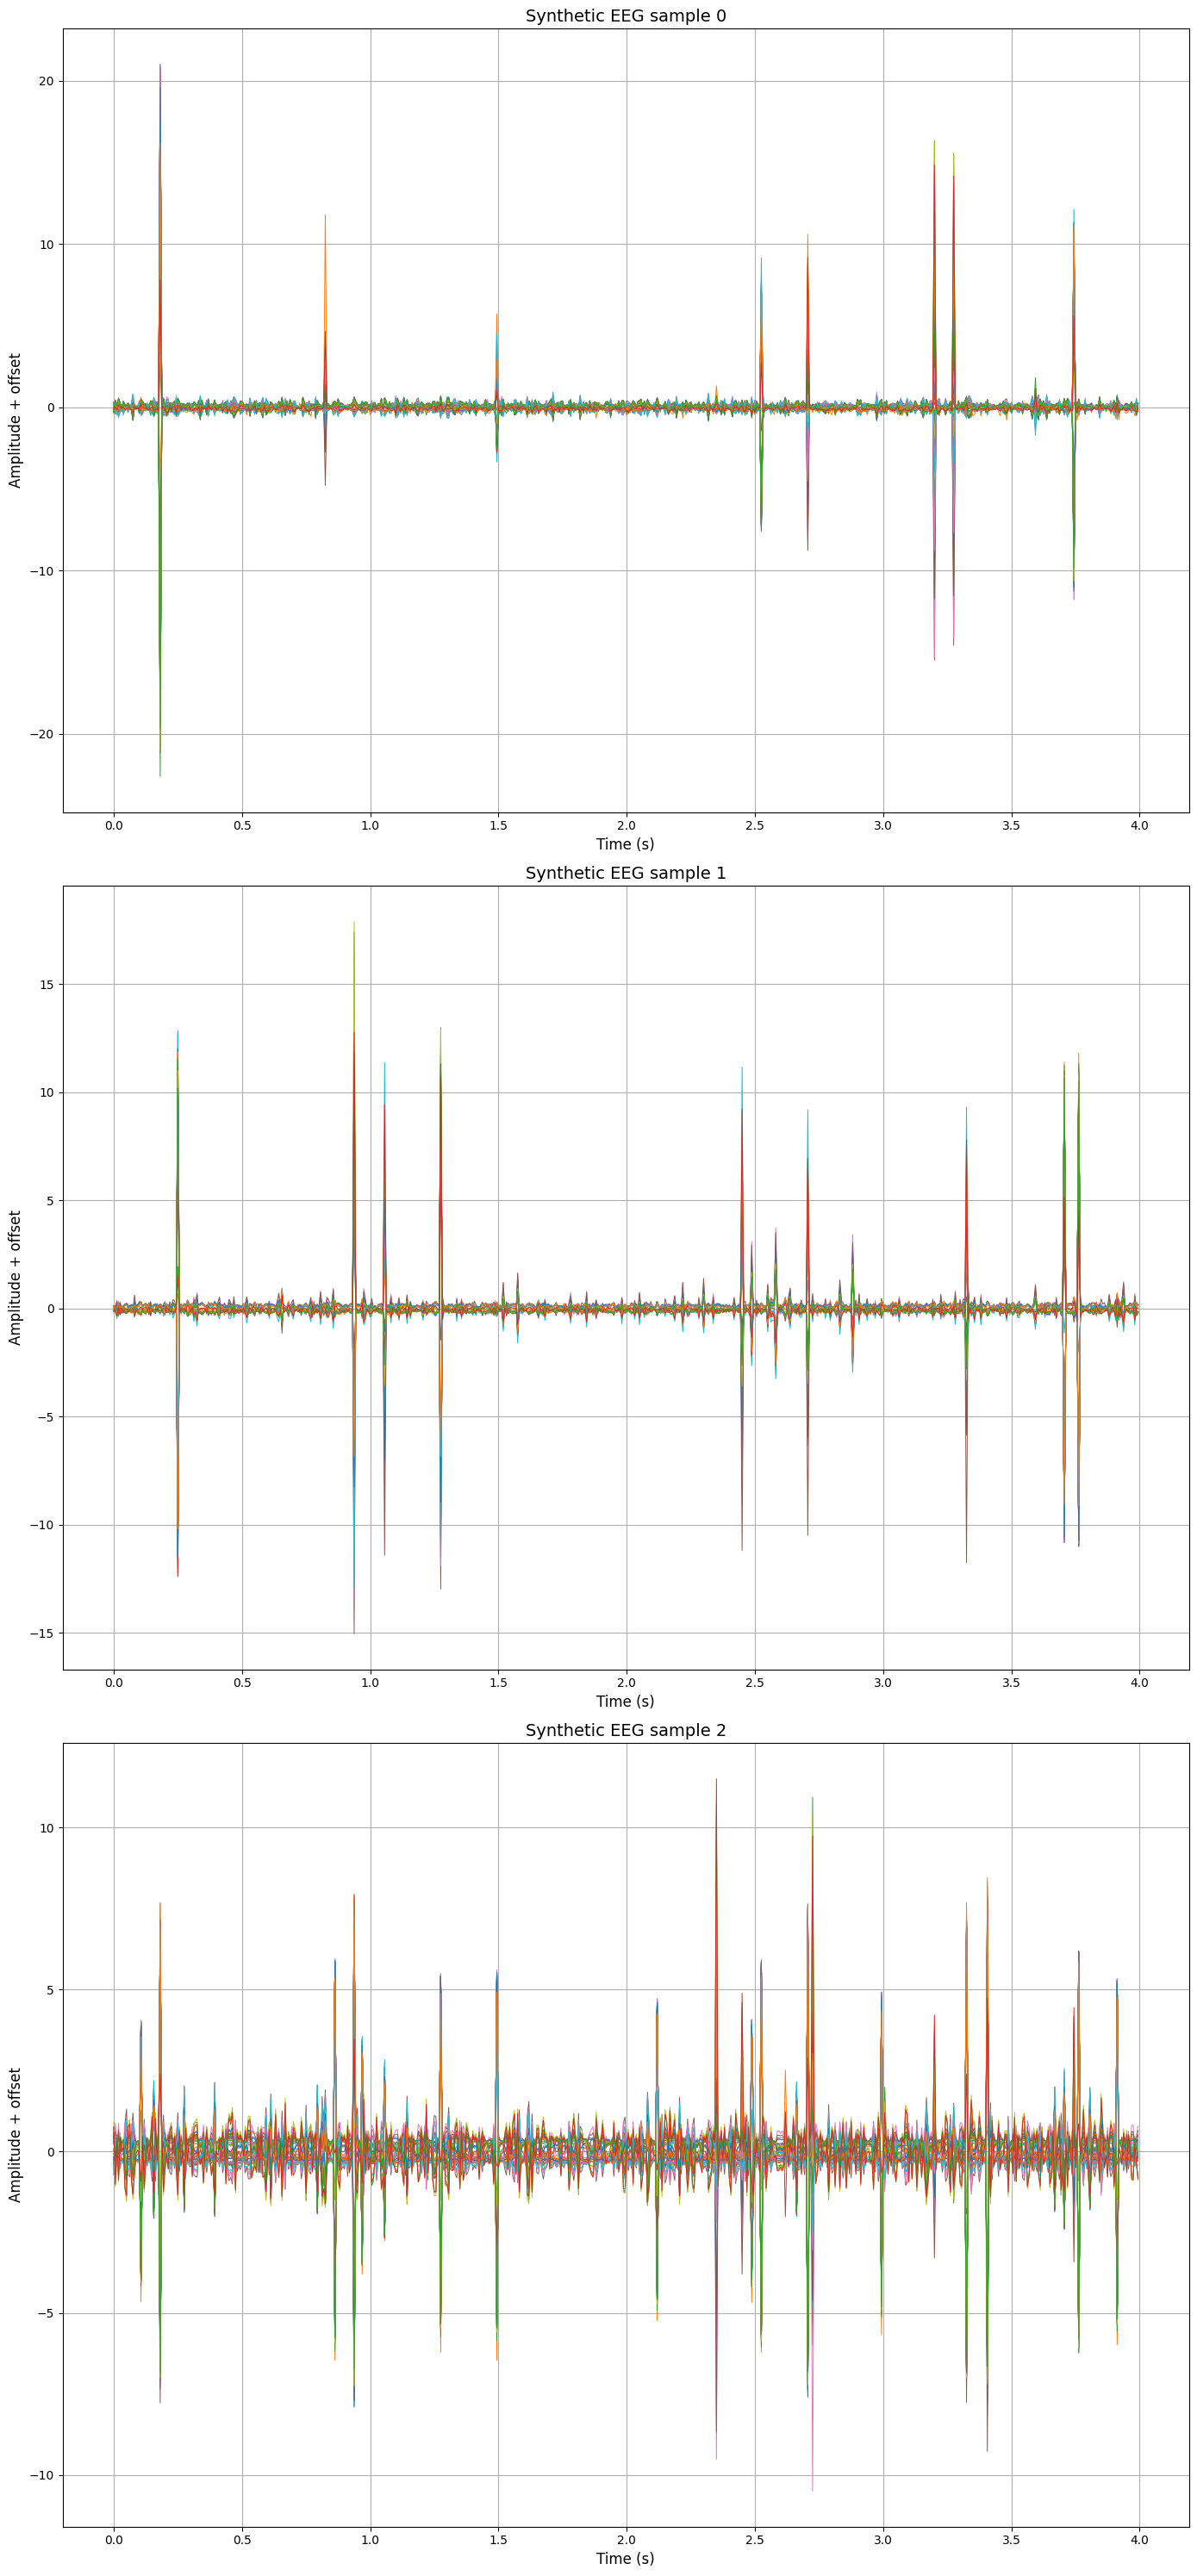

In [47]:
plot_eeg_signals_general(synthetic_dataset, label="Synthetic", n=3, spacing=0, figsize_scale=10)


In [48]:
plot_eeg_signals_general(real_dataset_by_class["left_hand"], label="Real", n=3, spacing=0, figsize_scale=10)


Output hidden; open in https://colab.research.google.com to view.